In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from navigation_game import NavigableNetwork
import scipy
import numpy as np
from vizman import viz
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import pdist, squareform

def evaluator(synthetic, empirical, euclidean_distance):
    degrees_synthetic = np.sum(synthetic, axis=0)
    degrees_empirical = np.sum(empirical, axis=0)
    ks_degree = ks_2samp(degrees_synthetic, degrees_empirical)
    
    clustering_synthetic = nx.clustering(nx.from_numpy_array(synthetic))
    clustering_empirical = nx.clustering(nx.from_numpy_array(empirical))
    ks_clustering = ks_2samp(list(clustering_synthetic.values()), list(clustering_empirical.values()))
    
    betweenness_synthetic = nx.betweenness_centrality(nx.from_numpy_array(synthetic))
    betweenness_empirical = nx.betweenness_centrality(nx.from_numpy_array(empirical))
    ks_betweenness = ks_2samp(list(betweenness_synthetic.values()), list(betweenness_empirical.values()))
    
    distance_synthetic = euclidean_distance[np.triu(synthetic, 1) > 0]
    distance_empirical = euclidean_distance[np.triu(empirical, 1) > 0]
    ks_distance = ks_2samp(distance_synthetic, distance_empirical)
    
    return np.max([ks_degree[0], ks_clustering[0], ks_betweenness[0], ks_distance[0]])

In [4]:
viz.set_visual_style()
default_sizes = viz.load_data_from_json("sizes.json")
default_colors = viz.load_data_from_json("colors.json")
default_cmaps = viz.give_colormaps()

In [5]:
default_colors

{'neutrals': {'BONE_WHITE': '#FFFCF2',
  'ALL_WHITE': '#FFFFFF',
  'GRAY': '#b8b8b8',
  'OLIVE_GRAY': '#6A7870',
  'HALF_BLACK': '#232324'},
 'colds': {'INK_BLUE': '#0F14F7',
  'NIGHT_BLUE': '#394D73',
  'DEEP_BLUE': '#006685',
  'LAKE_BLUE': '#3FA5C4',
  'TEAL': '#44cfcf'},
 'warms': {'SAND': '#E1C5A2',
  'YELLOW': '#E6B213',
  'ORANGE': '#F99465',
  'LECKER_RED': '#E84653',
  'DEEP_RED': '#BF003F'},
 'purples': {'PINK': '#EFBBD3',
  'PURPLE': '#A6587C',
  'PURPLER': '#591154',
  'PURPLEST': '#260126'},
 'greens': {'GRASS_GREEN': '#5DC400',
  'SLOW_GREEN': '#a1d4ca',
  'JUST_GREEN': '#4BAE6A',
  'LUXUARY_GREEN': '#275036',
  'ULTRA_GREEN': '#52FF94'}}

In [6]:
default_sizes

{'small': [5, 3],
 'half_column': [9, 5],
 'wide': [18, 9],
 'half_page': [18, 12],
 'full_page': [18, 16]}

In [7]:
default_cmaps

{'db_bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x167fb5710>,
 'nb_bw_dr': <matplotlib.colors.LinearSegmentedColormap at 0x16684e450>,
 'sg_bw_pi': <matplotlib.colors.LinearSegmentedColormap at 0x16684e1d0>,
 'bw_lr': <matplotlib.colors.LinearSegmentedColormap at 0x1681cea50>,
 'bw_db': <matplotlib.colors.LinearSegmentedColormap at 0x1685f9010>,
 'bw_hb': <matplotlib.colors.LinearSegmentedColormap at 0x1685f9d90>}

In [8]:
# Create test coordinates matching the paper's example
coords = np.array([
    [1, 1],  # A
    [3, 1],  # B
    [3, 2],  # C
    [1, 5],  # D
])

# Create network and get equilibrium
net = NavigableNetwork(coords)
equilibrium = net.build_nash_equilibrium()

# Print the adjacency matrix
print("Adjacency matrix:")
print(equilibrium.astype(int))


Adjacency matrix:
[[0 0 1 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


<Axes: >

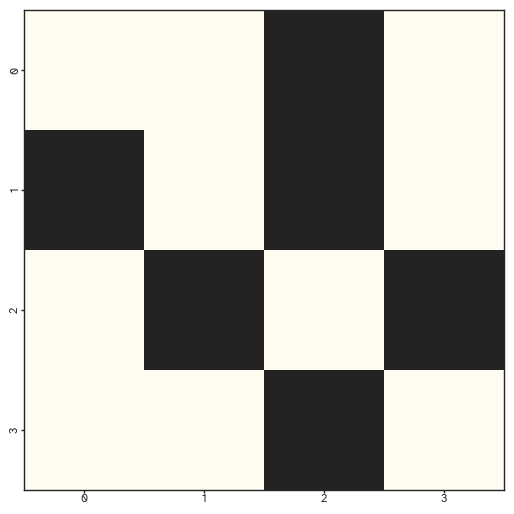

In [9]:
viz.plot_matrix(equilibrium, sns_kwargs={"cmap":default_cmaps["bw_hb"]})

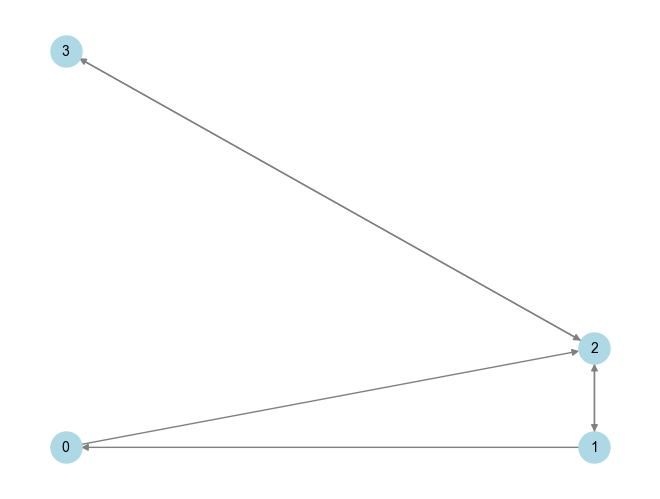

In [10]:

G = nx.from_numpy_array(equilibrium, create_using=nx.DiGraph)

# Extract positions of nodes
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos = coords, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_color='black', edge_color='gray')

In [11]:
res_parcellation = 1
consensus_mat = scipy.io.loadmat(
    "datasets/Consensus_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)
connectivity = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][0].astype(bool)
coordinates = consensus_mat["LauConsensus"]["Matrices"][res_parcellation][3]
euclidean_dis = squareform(pdist(coordinates, metric='euclidean'))


In [12]:
game = NavigableNetwork(coordinates)
nash_network = game.build_nash_equilibrium()

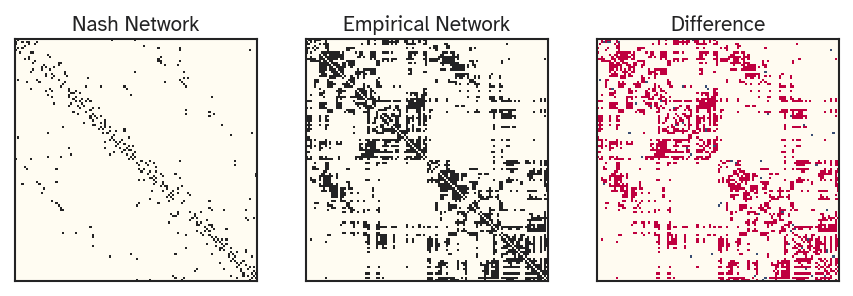

In [13]:
fig, axes = plt.subplot_mosaic([["A", "B","C"]], figsize=viz.cm_to_inch(default_sizes['half_page']), dpi=150)
viz.plot_matrix(nash_network.astype(int), axis=axes["A"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int), axis=axes["B"], sns_kwargs={"cmap":default_cmaps["bw_hb"], 
                                                                      "xticklabels":False, "yticklabels":False})
viz.plot_matrix(connectivity.astype(int)-nash_network.astype(int), axis=axes["C"], sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                                                               "xticklabels":False, "yticklabels":False})
axes["A"].set_title("Nash Network")
axes["B"].set_title("Empirical Network")
axes["C"].set_title("Difference");

In [117]:
from navigation_game import NetworkParameters, DevelopingNetwork, SimulationMode
from tqdm import tqdm

# Create parameters
# params = NetworkParameters(
#     alpha=1.0,
#     beta_infinity=1.0,
#     tau_beta=50.0,
#     t0=1.0,
#     tau_t=50.0,
#     connectivity_penalty=100.0,
#     n_flips_per_iteration=10,
#     seed=42
# )

fixed_params = NetworkParameters(
    mode=SimulationMode.FIXED,
    alpha=131,
    beta=0.12,
    temperature=0.0,
    connectivity_penalty=0.0
)
# Create network
network = DevelopingNetwork(coordinates, fixed_params)

# Run simulation
adjacency_history = network.simulate(n_iterations=5_000)
fit_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)



Evaluating network evolution: 100%|██████████| 5000/5000 [08:00<00:00, 10.41it/s]


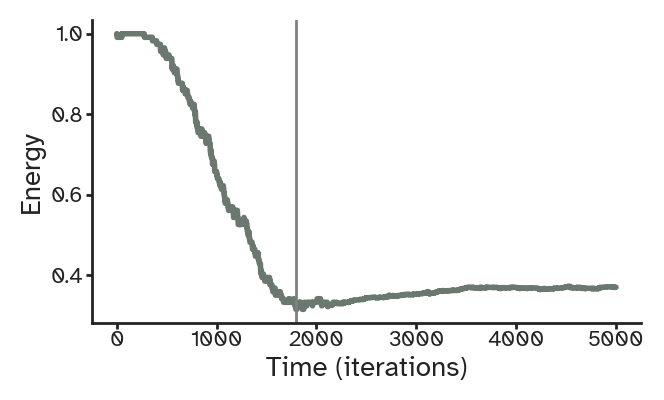

In [118]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(fit_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Energy")
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
sns.despine()

Evaluating network evolution:   0%|          | 0/5000 [00:00<?, ?it/s]

/Users/ICNS/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))
Evaluating network evolution: 100%|██████████| 5000/5000 [00:24<00:00, 201.16it/s]


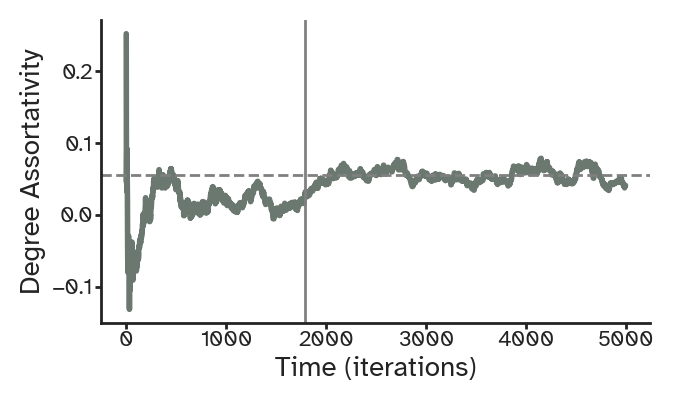

In [119]:
assortativity = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    assortativity[t] = nx.degree_assortativity_coefficient(nx.from_numpy_array(adjacency_history[:,:,t]))

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(assortativity,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Degree Assortativity")
empirical_assortativity = nx.degree_assortativity_coefficient(nx.from_numpy_array(connectivity))
plt.axhline(empirical_assortativity, color='gray', linestyle='--')
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

sns.despine()

Evaluating network evolution:   0%|          | 0/5000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 5000/5000 [00:14<00:00, 344.00it/s]


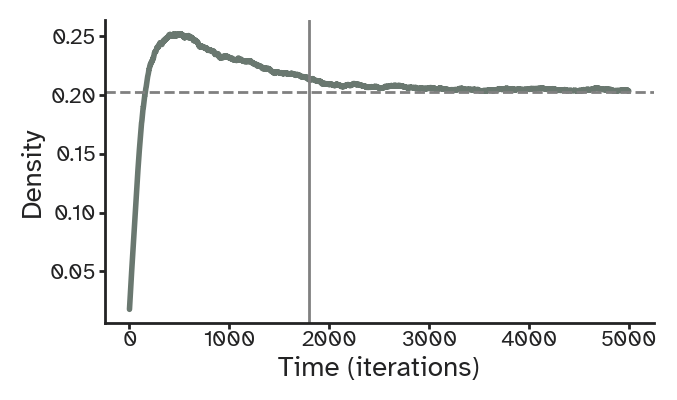

In [120]:
density = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    density[t] = nx.density(nx.from_numpy_array(adjacency_history[:,:,t]))

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(density,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Density")
empirical_density = nx.density(nx.from_numpy_array(connectivity))
plt.axhline(empirical_density, color='gray', linestyle='--')
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

sns.despine()

Evaluating network evolution:   0%|          | 0/5000 [00:00<?, ?it/s]

Evaluating network evolution: 100%|██████████| 5000/5000 [00:46<00:00, 108.56it/s]


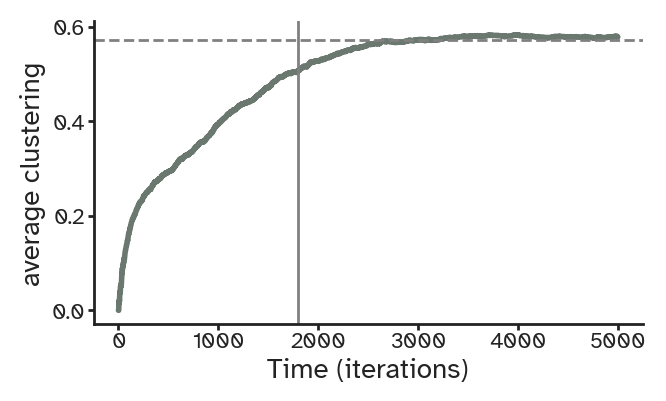

In [121]:
avg_clustering = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    avg_clustering[t] = nx.average_clustering(nx.from_numpy_array(adjacency_history[:,:,t]))
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(avg_clustering,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("average clustering")
empirical_average_clustering = nx.average_clustering(nx.from_numpy_array(connectivity))
plt.axhline(empirical_average_clustering, color='gray', linestyle='--')
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

sns.despine()

In [122]:
avg_spl = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    avg_spl[t] = nx.average_shortest_path_length(nx.from_numpy_array(adjacency_history[:,:,t]))

Evaluating network evolution: 100%|██████████| 5000/5000 [00:45<00:00, 110.37it/s]


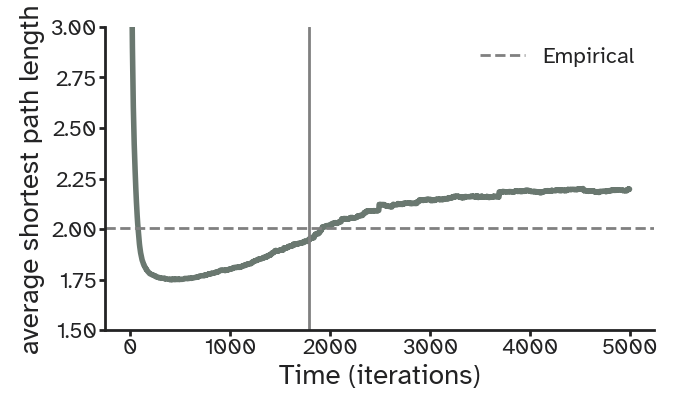

In [123]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(avg_spl,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("average shortest path length")
empirical_avg_spl = nx.average_shortest_path_length(nx.from_numpy_array(connectivity))
plt.axhline(empirical_avg_spl, color='gray', linestyle='--', label="Empirical")
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

plt.ylim(1.5, 3)
plt.legend(frameon=False)

sns.despine()

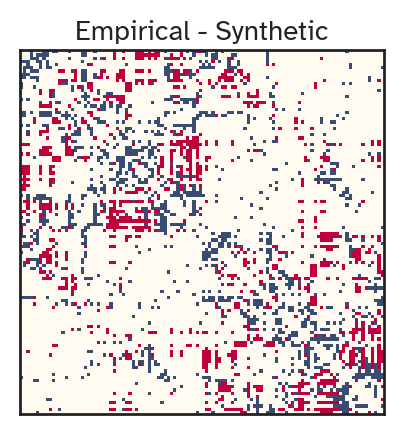

In [124]:
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(connectivity-best_fit_matrix, sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [32]:
from scipy.stats import spearmanr

In [125]:
degree_correlation = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    degree_correlation[t],_ = spearmanr(np.sum(adjacency_history[:,:,t], axis=0), np.sum(connectivity, axis=0))

Evaluating network evolution:   0%|          | 0/5000 [00:00<?, ?it/s]/Users/ICNS/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Evaluating network evolution: 100%|██████████| 5000/5000 [00:01<00:00, 3492.55it/s]


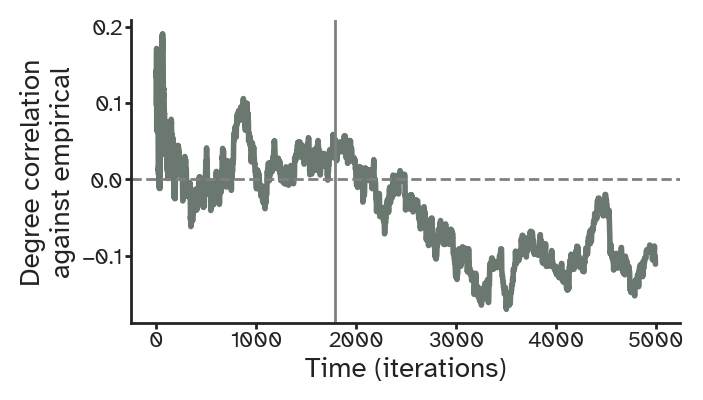

In [127]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(degree_correlation,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Degree correlation\nagainst empirical")
plt.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
plt.axhline(0, color='gray', linestyle='--')
sns.despine()

In [50]:
all_connectomes = scipy.io.loadmat(
    "datasets/Individual_Connectomes.mat",
    simplify_cells=True,
    squeeze_me=True,
    chars_as_strings=True,
)['connMatrices']['SC'][res_parcellation].astype(bool)

Evaluating intersubject correlation:   0%|          | 0/70 [00:00<?, ?it/s]

Evaluating intersubject correlation: 100%|██████████| 70/70 [00:00<00:00, 7319.90it/s]


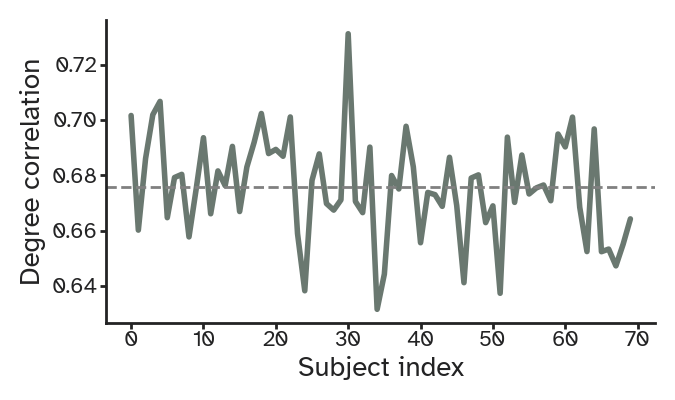

In [128]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
intersubject_correlation = np.zeros(all_connectomes.shape[2])
for i in tqdm(range(all_connectomes.shape[2]), desc="Evaluating intersubject correlation"):
    intersubject_correlation[i] = np.corrcoef(all_connectomes[:,:,i].ravel(), connectivity.ravel())[0,1]
plt.plot(intersubject_correlation,lw=2)
plt.axhline(np.mean(intersubject_correlation), color='gray', linestyle='--')
plt.xlabel("Subject index")
plt.ylabel("Degree correlation")
sns.despine()

Evaluating intersubject energy: 100%|██████████| 70/70 [00:06<00:00, 11.22it/s]


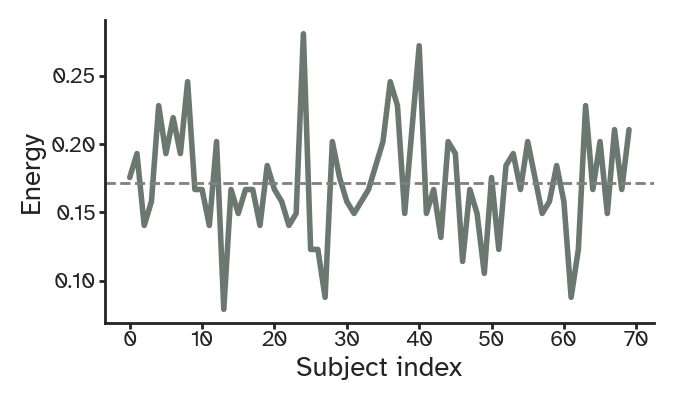

In [129]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
intersubject_energy = np.zeros(all_connectomes.shape[2])
for i in tqdm(range(all_connectomes.shape[2]), desc="Evaluating intersubject energy"):
    intersubject_energy[i] = evaluator(all_connectomes[:,:,i], connectivity, euclidean_dis)
plt.plot(intersubject_energy,lw=2)
plt.axhline(np.mean(intersubject_energy), color='gray', linestyle='--')
plt.xlabel("Subject index")
plt.ylabel("Energy")
sns.despine()

In [130]:
# Create a correlation matrix
n_timepoints = adjacency_history.shape[2]
n_subjects = all_connectomes.shape[2]
correlation_matrix = np.zeros((n_timepoints, n_subjects))

# Calculate degree correlations
for t in tqdm(range(n_timepoints), desc="Computing correlations"):
    synthetic_degrees = np.sum(adjacency_history[:,:,t], axis=0)
    for s in range(n_subjects):
        empirical_degrees = np.sum(all_connectomes[:,:,s], axis=0)
        correlation_matrix[t,s], _ = spearmanr(synthetic_degrees, empirical_degrees)

Computing correlations:   0%|          | 0/5000 [00:00<?, ?it/s]/Users/ICNS/Library/Mobile Documents/com~apple~CloudDocs/Work/Optimal_networks/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
Computing correlations: 100%|██████████| 5000/5000 [01:18<00:00, 63.63it/s]


/var/folders/jj/cg03q6f13lb9h32fwmdrmzrm0000gp/T/ipykernel_10228/401077308.py:2: RuntimeWarning: Mean of empty slice
  mean_correlation = np.nanmean(correlation_matrix, axis=1)
/var/folders/jj/cg03q6f13lb9h32fwmdrmzrm0000gp/T/ipykernel_10228/401077308.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


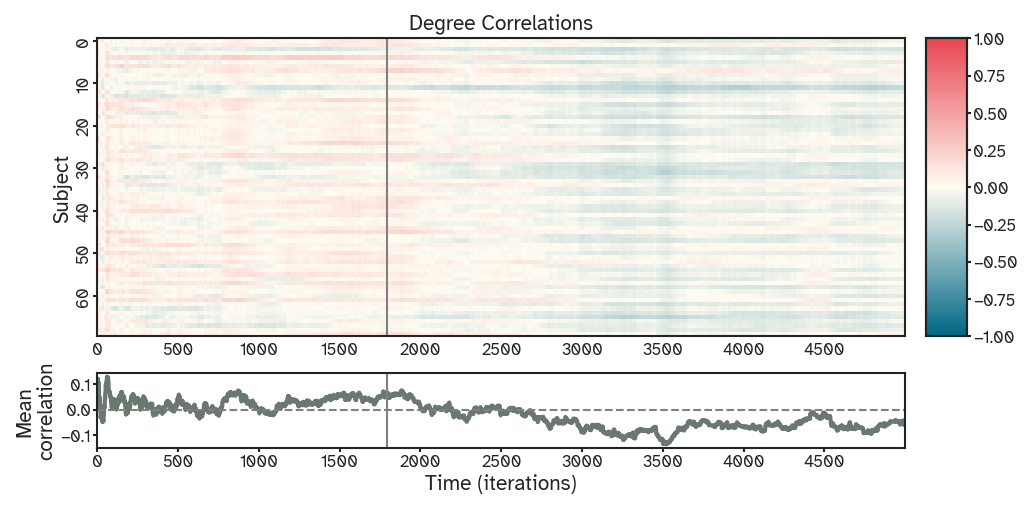

In [142]:
# Calculate mean correlation across subjects for each timepoint
mean_correlation = np.nanmean(correlation_matrix, axis=1)

fig = plt.figure(figsize=viz.cm_to_inch((19,9)), dpi=150)
gs = fig.add_gridspec(2, 2, height_ratios=[4, 1], width_ratios=[20, 1], hspace=0.2, wspace=0.05)

# Top subplot (heatmap)
ax_heatmap = fig.add_subplot(gs[0, 0])
im = sns.heatmap(correlation_matrix.T, 
                 cmap=default_cmaps['db_bw_lr'],
                 vmax=1, vmin=-1,
                 center=0,
                 yticklabels=10, 
                 xticklabels=500,
                 ax=ax_heatmap,
                 cbar=False)
ax_heatmap.set_ylabel("Subject")
ax_heatmap.set_title("Degree Correlations")
ax_heatmap.axvline(np.argmin(fit_vector), color='gray', linestyle='-')
# Colorbar as extension of the heatmap
cbar_ax = fig.add_subplot(gs[0, 1])
plt.colorbar(im.collections[0], cax=cbar_ax)

# Bottom subplot (mean correlation)
ax_line = fig.add_subplot(gs[1, 0], sharex=ax_heatmap)
ax_line.plot(mean_correlation, lw=2,)
ax_line.set_xlabel("Time (iterations)")
ax_line.set_ylabel("Mean\ncorrelation")
ax_line.axhline(0, color="gray", linestyle="--")
ax_line.axvline(np.argmin(fit_vector), color='gray', linestyle='-')

# Align x-axes and tidy up
ax_heatmap.tick_params(axis='x', which='both', bottom=False)
sns.despine(fig=fig, top=False, right=False)
plt.tight_layout()

In [143]:
max_indices = np.unravel_index(np.nanargmax(correlation_matrix), correlation_matrix.shape)
print(f"Maximum correlation found at time step {max_indices[0]} and subject {max_indices[1]}")
print(f"Maximum correlation value: {correlation_matrix[max_indices]}")

Maximum correlation found at time step 61 and subject 54
Maximum correlation value: 0.28721591609534625


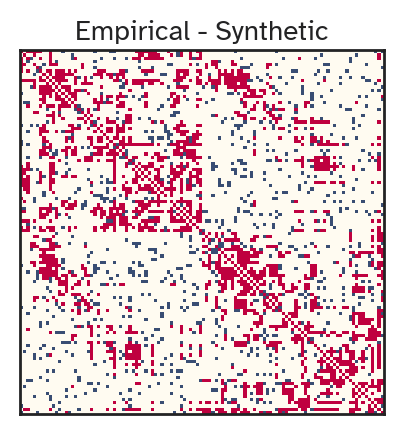

In [145]:
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(all_connectomes[:,:,54]-adjacency_history[:,:,61], sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [112]:
from navigation_game import ParameterSpace, NetworkFitter, SimulationMode

param_space = ParameterSpace(
    param_ranges={
        'alpha': (100.0, 200.0),
        'beta': (0.01, 1),
    },
    fixed_params={
        'connectivity_penalty': 0.0,
        'temperature': 0.0,
    }
)

fitter = NetworkFitter(
    coordinates=coordinates,
    empirical_adj=connectivity,
    parameter_space=param_space,
    mode=SimulationMode.FIXED,
    n_trials=80,
    n_iterations=2500,
)

results = fitter.fit()

Fitting parameters: 100%|██████████| 80/80 [3:50:27<00:00, 172.84s/it]


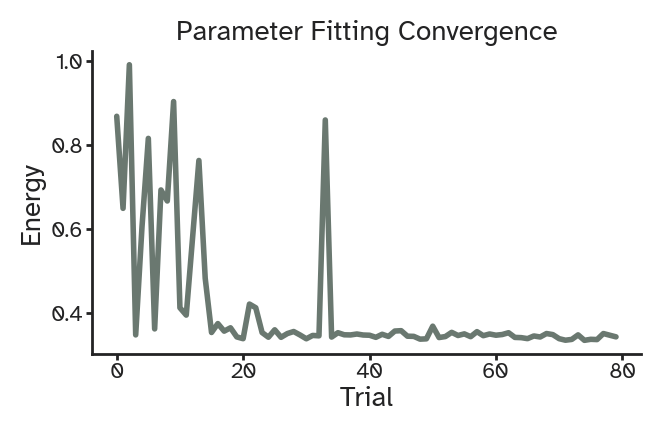

In [113]:
plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(results.all_scores,lw=2)
plt.xlabel('Trial')
plt.ylabel('Energy')
plt.title('Parameter Fitting Convergence')
sns.despine()

In [114]:
results.best_params

{'alpha': 131.0213096776186,
 'beta': 0.12037557409630248,
 'connectivity_penalty': 0.0,
 'temperature': 0.0}

In [115]:
results.best_score

0.33470178844891707

Evaluating network evolution: 100%|██████████| 3000/3000 [04:44<00:00, 10.56it/s]


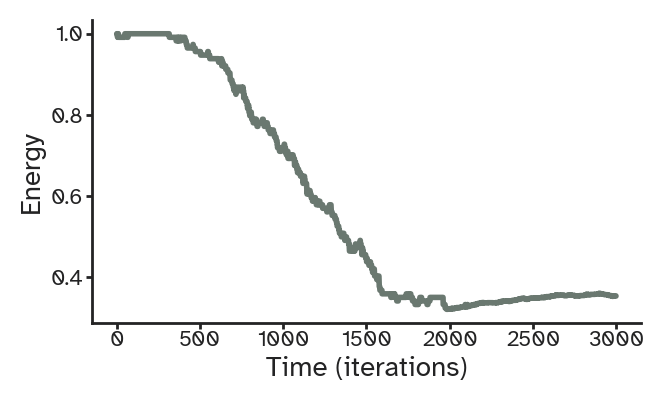

In [116]:
fixed_params = NetworkParameters(
    mode=SimulationMode.FIXED,
    alpha=results.best_params['alpha'],
    beta=results.best_params['beta'],
    temperature=0.0,
    connectivity_penalty=0.0
)
# Create network
network = DevelopingNetwork(coordinates, fixed_params)

# Run simulation
adjacency_history = network.simulate(n_iterations=3_000)
fit_vector = np.zeros(adjacency_history.shape[2])
for t in tqdm(range(adjacency_history.shape[2]), desc="Evaluating network evolution"):
    fit_vector[t] = evaluator(adjacency_history[:,:,t], connectivity, euclidean_dis)

plt.figure(figsize=viz.cm_to_inch(default_sizes['half_column']), dpi=200)
plt.plot(fit_vector,lw=2)
plt.xlabel("Time (iterations)")
plt.ylabel("Energy")
sns.despine()

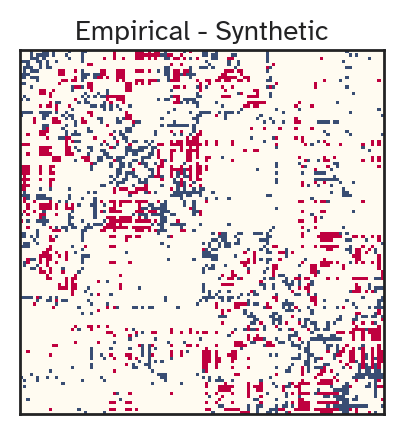

In [110]:
best_fit_matrix = adjacency_history[:,:,np.argmin(fit_vector)]
plt.figure(figsize=viz.cm_to_inch((6,6)), dpi=200)
ax = plt.subplot(111)
viz.plot_matrix(connectivity-best_fit_matrix, sns_kwargs={"cmap":default_cmaps["nb_bw_dr"], 
                                                          "xticklabels":False, 
                                                          "yticklabels":False}, axis=ax)
plt.title("Empirical - Synthetic");

In [55]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from numpy.typing import NDArray
from typing import Optional

def animate_network_evolution(coordinates: NDArray[np.float64], 
                            adjacency_history: NDArray[np.int8],
                            interval: int = 50,
                            save_path: Optional[str] = None) -> FuncAnimation:
    """
    Create an animation of network evolution over time.
    
    Args:
        coordinates: Array of shape (n_nodes, 2) containing node coordinates
        adjacency_history: Array of shape (n_nodes, n_nodes, n_timesteps) 
                         containing adjacency matrices at each timestep
        interval: Time between frames in milliseconds
        save_path: Optional path to save animation (e.g., "animation.gif")
    
    Returns:
        matplotlib.animation.FuncAnimation object
    """
    # Setup the figure
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect('equal')
    
    # Create networkx graph
    G = nx.Graph()
    G.add_nodes_from(range(len(coordinates)))
    pos = {i: coordinates[i] for i in range(len(coordinates))}
    
    # Initialize plot elements
    node_collection = nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                                           node_size=300, ax=ax)
    edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
    time_text = ax.text(0.02, 0.98, '', transform=ax.transAxes,
                       fontsize=12, ha='left', va='top')
    
    # Set animation properties
    node_collection.set_animated(True)
    time_text.set_animated(True)
    
    def update(frame):
        """Update animation for each frame"""
        # Clear current edges
        if len(ax.collections) > 1:
            ax.collections[1].remove()
        
        # Get current adjacency matrix
        adj = adjacency_history[:, :, frame]
        
        # Update edges
        edge_list = [(i, j) for i in range(len(adj)) 
                    for j in range(i+1, len(adj)) if adj[i,j]]
        G.clear_edges()
        G.add_edges_from(edge_list)
        
        # Draw new edges
        edge_collection = nx.draw_networkx_edges(G, pos, ax=ax)
        
        # Update timestep text
        time_text.set_text(f'Timestep: {frame}')
        
        return node_collection, edge_collection, time_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=adjacency_history.shape[2],
                        interval=interval)
    
    # Save if path provided
    if save_path:
        anim.save(save_path, writer='pillow')
    
    plt.close()
    return anim

In [63]:
anim = animate_network_evolution(coordinates[:, :2], adjacency_history[:,:,::10], save_path='network_evolution.gif')